# COVID-19 Topic Modeling & Article Similarity Matching

This Jupyter Notebook takes data published in the Kaggle COVID-19 challenge and creates a topic model on a subset of the data, and uses FAISS to find the most similar articles in the training set to an unseen article.

The source data can be found here: https://www.kaggle.com/covid19

Possible extensions are to scale up to the total dataset removing the random sampling of the dataset, improving the presentation of the results, and getting to a more granular similarity matching at the sentence level.

First we'll import required packages, and install a few packages as well.

In [1]:
import numpy as np
import pandas as pd
import re
import json
import sys
import os
import ast
import random
pd.set_option('display.max_columns', 40)

In [2]:
!{sys.executable} -m pip install nltk gensim wordcloud faiss-cpu

import nltk
import gensim
import wordcloud
import faiss
from nltk.corpus import stopwords
from helper_functions import *

# Data Processing

Next let's load and process the articles. The first step will be to load the articles, which have been downloaded onto my local machine. Due to memory related issues, we'll randomly sample 20% of the articles from each source. This is not ideal, but the sample size created is still large (>3000 articles).

These functions pull data sourced from my location machine, I've downloaded the data from Kaggle and am loading it that way. Not ideal for reproducability, but just change the file locations listed below if your files are in another location, and make sure there's no other data outside of the kaggle-provided data in those locations.

In [3]:
file_locations = ['biorxiv_medrxiv/biorxiv_medrxiv', 
                  'noncomm_use_subset/noncomm_use_subset', 
                  'comm_use_subset/comm_use_subset',
                  'custom_license/custom_license']

## Set up Stop Words
## Add Any other relevant options manually

stop_words = stopwords.words('english') + ['et', 'al', 'fig', 'etal', 'et al', 'et-al']

processed_articles = process_articles(file_locations, stop_words)
processed_articles.read_files()

print('Example File Name')
print(processed_articles.root_files[0])
print('Number of files')
print(len(processed_articles.root_files))
print('Example Article Information')
print(processed_articles.title_text[2])

Processing Files at the below location:
biorxiv_medrxiv/biorxiv_medrxiv
There are 177 files to process
There were 885 files in the dataset
Processing Files at the below location:
noncomm_use_subset/noncomm_use_subset
There are 470 files to process
There were 2353 files in the dataset
Processing Files at the below location:
comm_use_subset/comm_use_subset
There are 1823 files to process
There were 9118 files in the dataset
Processing Files at the below location:
custom_license/custom_license
There are 3391 files to process
There were 16959 files in the dataset
Example File Name
5078f271f0b8d13359084747a8244563005d720a.json
Number of files
3391
Example Article Information
['biorxiv_medrxiv', 'Title: Feasibility of controlling 2019-nCoV outbreaks by isolation of cases and contacts', ['Evidence before this study Contact tracing and isolation of cases is a commonly used intervention for controlling infectious disease outbreaks. This intervention can be effective, but may require intensive p

Next let's process the text - this involves removing links and other undesirable text, tokenizing words from the raw paragraph text, removing stop words (the, it etc...) and finally creating stems of words to group derivatives of the same root word together.

There's no contextual meaning associated with these stems, which is why word embedding based approaches have grown in popularity as the vectors they create attempt to capture the contextual meaning of words based on the words around them rather than just represent the raw text. Shifting to that type of approach is a logical extension of this initial work

In [4]:
processed_articles.process_text()

Cleaning out Junk
Tokenizing words
Converting to list of words and removing stop words
Creating word stems


Next we'll create bigrams and trigrams of the data - this concatenates words that are used frequently with one and other to create their own representation. As an example, *multicellular_eukaryot* is a bigram create based on these two words appearing frequently in the text corpus. *oil_immers_object* is a trigram created for the same reason, the only difference is an additional word on the end.

In [5]:
processed_articles.trigrams([art[3] for art in processed_articles.processed_article])
processed_articles.processed_trigrams[2][4]

Creating Bigrams
Creating Trigrams from Bigrams


"['evid', 'studi', 'contact_trace', 'isol', 'case', 'commonli_use', 'intervent', 'control', 'infecti_diseas_outbreak', 'intervent', 'effect', 'may', 'requir', 'intens', 'public_health', 'effort', 'cooper', 'effect', 'reach', 'monitor', 'contact', 'pathogen', 'infecti', 'symptom_onset', 'control', 'outbreak', 'use', 'contact_trace', 'isol', 'challeng', 'studi', 'use', 'mathemat_model', 'assess', 'feasibl', 'contact_trace', 'case', 'isol', 'control', 'outbreak', 'ncov', 'newli_emerg_pathogen', 'use', 'diseas', 'transmiss', 'characterist', 'specif', 'pathogen', 'therefor', 'give', 'best', 'avail', 'evid', 'contact_trace', 'isol', 'achiev', 'control', 'outbreak', 'contact_trace', 'isol', 'may', 'contain', 'outbreak', 'ncov', 'unless', 'high_level', 'contact_trace', 'achiev', 'even', 'case', 'asymptomat', 'transmiss', 'high', 'fraction', 'transmiss', 'onset_symptom', 'strategi', 'may', 'achiev', 'control', 'within', 'three', 'month', 'th_februari', 'confirm', 'case', 'novel_coronaviru', 'in

Next let's split the data into train and test, in this case the test data is used to compute perplexity as well as to have a held out set for similarity matching used later. The model with the lowest perplexity is used as the final model. Topic Coherence is another method used to evaluate the quality of topic creation, but that was not pursued in this example.

Often topics are manually reviewed to determine the appropriate number of topics, but in this case I don't have enough subject matter expertise to provide any value.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

train, test = train_test_splitter(processed_articles.processed_trigrams, 0.90)

vectorizer = CountVectorizer(min_df = 50, max_df = 0.8, max_features = 50000)
tf = vectorizer.fit_transform([t[4] for t in train]) ## Vectorize training set
tf_feature_names = vectorizer.get_feature_names() ## Pull out words for use in eval

# Transform test data for perplexity eval

tf_test = vectorizer.transform([t[4] for t in test])

# Modeling - LDA

Next let's build the topic model. We'll use Latent Dirichlet Allocation (LDA), specifically the implementation from sklearn. The key concept of LDA is that there are latent topics that exist within a document corpus based on words used in each document. LDA is an unsupervised probablistic model where documents are probability distributions over latent topics, and topics are probability distributions over words. In simplistic terms, LDA aims to find collections of words that are disproportionately represented within documents relative to the total document corpus to identify latent topics.

LDA is not a supervised model, a practitioner provides processed text and a number of topics, and LDA creates the specified number of topics based on observed probability distributions of words within documents. LDA is a bag of words model evaluated within each document, so the order of words is immaterial.

For each document LDA assumes all topic assignments are correct except for the document in question. From there, it calculates two proportions. The first is the proportion of words in the current document that are assigned to a specific topic. Then the proportion of assignments to that topic over all documents that come from each word. These proportions get multiplied across all words and topics to update the probabilities that a word is assigned to a topic.

LDA trades off two adversarial goals to find the appropriate distributions. The first is in each document it wants to allocate words to as few topics as possible, the second is for each topic it wants to assign high probability to few words.

The end outcome is each document receives a distribution of scores across each topic that sums to 1. The higher the score for a particular topic, the more representative a topic is of that document. We can also evaluate each topic to see which words are most prevalent in total, and relative to how prevalent they are relative to total word usage in the overall corpus

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
perps = []
models = []

# Below was used for testing to find optimal number of topics based on test data perplexity. 
# Commented out for brevity's sake in the notebook - using number of topics with lowest perplexity from testing

'''

for num_top in range(20,40,1):
    
    #'online': Online variational Bayes method. In each EM update, use
    #mini-batch of training data to update the ``components_``
    #variable incrementally.
    # Controlled by learning offset and decay functions
    # Offset & decay good candidates for optimization
    
    lda = LatentDirichletAllocation(n_components=num_top,
                                    learning_method = 'online',
                                    verbose = 1,
                                    learning_offset = 15., # Downweights early iterations
                                    learning_decay = 0.75, # default = 0.7
                                    random_state = 100
                                   )
    print(f"{num_top} topics")
    print('fitting')
    ldamod = lda.fit(tf)
    perp = ldamod.perplexity(tf_test)
    print(f'Perplexity for {num_top}')
    print(perp)
    perps.append(perp)
    models.append(ldamod)

'''

lda = LatentDirichletAllocation(n_components=32,
                                    learning_method = 'online',
                                    verbose = 1,
                                    learning_offset = 15., # Downweights early iterations
                                    learning_decay = 0.75, # default = 0.7
                                    random_state = 100
                                   )

ldamod = lda.fit(tf)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [8]:
evalinfo = LDA_Evaluator(lda_model = ldamod, vectorizer = vectorizer)

Next let's look at the word frequency within a topic to get a better understanding of topic composition. The first table shows the top 20 words in terms of frequency within topic 3\0. The second shows the top 20 words in terms of frequency relative to all other topics for topic 0. Both of these are based off the components_ provided by the LDA implementation, which is described as a "pseudocount that represents the number of times word j was assigned to topic i."

In [18]:
# Evaluate words that are highest per topic
# Use topic three as an example 

evalinfo.eval_raw_frequency(0, 20)

0         1             2             3         4  \
target    0.101290  0.000939  5.281274e-05  2.132791e-07  0.000033   
sirna     0.089696  0.000001  1.165966e-07  2.109217e-07  0.000032   
mirna     0.053970  0.000001  1.147012e-07  2.148429e-07  0.000032   
mir       0.041585  0.000001  1.146349e-07  1.444311e-05  0.000032   
rna       0.037603  0.002524  2.910075e-06  4.165650e-07  0.000033   
ard       0.027961  0.000001  1.154286e-07  2.090933e-07  0.000032   
trim      0.026333  0.000001  1.148523e-07  2.919443e-05  0.000033   
mrna      0.026194  0.000001  1.280461e-07  2.126279e-07  0.000033   
rnai      0.022365  0.000001  1.147199e-07  2.119772e-07  0.000032   
small     0.022334  0.004105  4.276121e-04  2.125397e-07  0.000033   
silenc    0.014428  0.000001  1.150074e-07  2.099940e-07  0.000032   
nc        0.013884  0.000001  1.146332e-07  2.091677e-07  0.000033   
regul     0.013862  0.000011  2.177816e-05  2.196272e-07  0.000035   
vzv       0.012599  0.000001  1.146277e-07  2.090188e-07  0.000032   
microrna  0.012152  0.000001  1.146383e-07  2.092337e-07  0.000032   
process   0.011988  0.001226  1.250286e-04  2.296426e-07  0.000033   
human     0.011764  0.007521  1.119115e-03  2.687468e-07  0.000034   
degrad    0.010385  0.000001  1.250566e-07  2.101674e-07  0.000033   
express   0.010174  0.000803  2.933880e-04  2.295288e-04  0.000035   
found     0.010050  0.000093  3.160303e-03  2.188614e-07  0.000033   

                     5             6             7             8  \
target    1.605499e-04  2.515657e-04  1.307622e-03  1.798874e-04   
sirna     1.507854e-07  7.565400e-08  6.102979e-07  5.685814e-08   
mirna     1.505791e-07  7.549117e-08  6.616091e-08  5.704101e-08   
mir       1.505746e-07  7.539899e-08  6.487023e-08  5.689463e-08   
rna       1.523443e-07  5.788063e-04  6.683204e-04  2.130990e-05   
ard       1.515348e-07  7.567411e-08  6.471149e-08  4.316652e-04   
trim      1.505517e-07  7.691249e-08  5.125828e-06  5.728602e-08   
mrna      1.508014e-07  8.433369e-08  8.688497e-06  6.312679e-08   
rnai      1.505638e-07  7.544419e-08  1.431271e-06  5.678721e-08   
small     2.599986e-03  8.659062e-04  6.895716e-04  4.157269e-04   
silenc    1.508147e-07  7.541754e-08  5.292409e-07  5.678697e-08   
nc        1.505865e-07  7.571276e-08  2.016797e-05  5.685905e-08   
regul     1.520781e-07  6.890665e-05  1.654436e-04  3.118408e-05   
vzv       1.505970e-07  7.544043e-08  1.175931e-07  2.414052e-04   
microrna  1.505932e-07  7.551074e-08  6.633404e-08  5.679899e-08   
process   4.146304e-03  3.016528e-04  4.402475e-03  5.316730e-04   
human     2.189960e-04  2.928860e-02  1.347185e-03  2.548825e-04   
degrad    1.508387e-07  3.037378e-07  7.431455e-04  6.060620e-08   
express   1.135039e-03  6.382451e-06  1.673883e-04  4.666776e-05   
found     5.370540e-04  3.952129e-03  2.442879e-03  2.228654e-03   

                     9            10            11            12        13  \
target    1.114039e-05  1.146986e-04  1.201780e-03  4.325360e-04  0.000024   
sirna     1.242731e-07  9.169102e-08  3.642074e-07  6.743634e-08  0.000023   
mirna     1.243372e-07  9.127713e-08  7.409130e-08  6.793933e-08  0.000023   
mir       1.238139e-07  7.049314e-08  7.409636e-08  6.733820e-08  0.000023   
rna       8.428306e-05  4.994586e-03  2.012975e-05  7.865787e-08  0.000023   
ard       1.260825e-07  6.722224e-08  8.846299e-08  1.043329e-07  0.000023   
trim      2.917528e-07  9.832564e-05  4.054604e-05  6.843654e-08  0.000023   
mrna      1.255155e-07  6.379070e-05  8.798134e-07  6.924345e-08  0.000023   
rnai      1.238394e-07  1.294445e-07  7.471084e-08  6.723157e-08  0.000023   
small     6.632290e-04  9.417286e-04  6.952401e-04  1.257588e-03  0.000023   
silenc    1.239500e-07  1.911164e-07  2.030746e-05  6.724030e-08  0.000023   
nc        1.737211e-04  1.191067e-04  9.834488e-06  7.091629e-08  0.000023   
regul     1.229377e-05  6.509917e-05  7.517916e-04  2.603441e-04  0.000023   
vzv       1.243759e-07  7

In [19]:
## Evaluate the words that show up the most relative to other topics for each topic

evalinfo.eval_rel_frequency(0, 20)

0         1         2         3         4  \
mirna              31.872329  0.000630  0.000068  0.000127  0.019186   
mir                31.823682  0.000814  0.000088  0.011053  0.024864   
sirna              31.753101  0.000377  0.000041  0.000075  0.011500   
rnai               31.530564  0.001506  0.000162  0.000299  0.045807   
ard                31.214176  0.001188  0.000129  0.000233  0.036279   
microrna           31.179012  0.002730  0.000294  0.000537  0.083353   
trim               31.093748  0.001264  0.000136  0.034473  0.038390   
gene_silenc        30.905200  0.004056  0.000438  0.000799  0.123833   
vzv                30.871544  0.003437  0.000281  0.000512  0.079602   
silenc             30.614725  0.002257  0.000244  0.000446  0.068931   
ago                30.383600  0.005390  0.315808  0.001258  0.164362   
nc                 29.321802  0.002249  0.000242  0.000442  0.068696   
fan                29.067772  0.006743  0.333357  0.001325  0.205885   
post_transcript    28.506624  0.012389  0.001330  0.002428  0.376943   
rna_interfer_rnai  28.387760  0.016040  0.001721  0.003140  0.487944   
knockdown          28.114672  0.005828  0.000524  0.000957  0.148536   
lung_cancer        27.863159  0.008154  0.000878  0.001599  0.248557   
non_code           27.647557  0.008878  0.000958  0.001738  0.270635   
endonucleas        26.612041  0.010283  0.001107  0.002021  0.313656   
biogenesi          26.005810  0.012612  0.001359  0.002480  0.385111   

                          5         6         7         8         9        10  \
mirna              0.000089  0.000045  0.000039  0.000034  0.000073  0.000054   
mir                0.000115  0.000058  0.000050  0.000044  0.000095  0.000054   
sirna              0.000053  0.000027  0.000216  0.000020  0.000044  0.000032   
rnai               0.000212  0.000106  0.002018  0.000080  0.000175  0.000182   
ard                0.000169  0.000084  0.000072  0.481895  0.000141  0.000075   
microrna           0.000386  0.000194  0.000170  0.000146  0.000318  0.000230   
trim               0.000178  0.000091  0.006053  0.000068  0.000345  0.116103   
gene_silenc        0.000574  0.000287  0.001415  0.000216  0.000473  0.000299   
vzv                0.000369  0.000185  0.000288  0.591531  0.000305  0.000180   
silenc             0.000320  0.000160  0.001123  0.000120  0.000263  0.000406   
ago                0.000762  0.000383  0.000383  0.000289  0.000627  0.116938   
nc                 0.000318  0.000160  0.042593  0.000120  0.366882  0.251542   
fan                0.000960  0.000479  0.429358  0.164830  0.000786  0.067409   
post_transcript    0.001747  0.000875  0.000787  0.000659  0.001436  0.000809   
rna_interfer_rnai  0.002261  0.001132  0.001043  0.000853  0.001859  0.044831   
knockdown          0.000688  0.000345  0.000411  0.000260  0.000566  0.000435   
lung_cancer        0.001152  0.000577  0.000532  0.267308  0.000947  0.000508   
non_code           0.001253  0.000635  0.000584  0.000473  0.001029  0.589481   
endonucleas        0.001454  0.000730  0.078150  0.000550  0.001196  0.382850   
biogenesi          0.001785  0.000894  0.000816  0.000673  0.001467  0.001685   

                         11        12        13        14        15        16  \
mirna              0.000044  0.000040  0.013452  0.061864  0.000102  0.001739   
mir                0.000057  0.000052  0.017430  0.080169  0.000132  0.002247   
sirna              0.000129  0.000024  0.008090  0.037168  0.000061  0.001044   
rnai               0.000105  0.000095  0.032121  0.147706  0.000244  0.004140   
ard                0.000099  0.000116  0.025434  0.116969  0.000194  0.003276   
microrna           0.000190  0.000173  0.058440  0.268796  0.000444  0.007528   
trim               0.047877  0.000081  0.026969  0.123719  0.000204  0.003479   
gene_silenc        0.000289  0.000256  0.086904  0.399443  0.000660  0.011215   
vzv                0.003659  0.000165  0.055818  0.256694  0.000424  0.007190   
si

In [11]:
train_wc = wcEval(train, vectorizer, ldamod)
train_wc.raw_freq_wc()
train_wc.rel_freq_wc()

test_wc = wcEval(test, vectorizer, ldamod)

train_topic_fin_raw = [[t[0], t[2], primary_top] for t, primary_top in zip(train, train_wc.raw_primary_topic)]
train_topic_fin_rel = [[t[0], t[2], rel_primary_top] for t, rel_primary_top in zip(train, train_wc.rel_primary_topic)]

It can be challenging to interpret topics this way, especially when the number of topics is larger. Another approach is to create a word cloud that displays the most frequently used words in a corpus in a visual way. We'll create a word cloud for each topic by assigning a document to the topic that it has the highest score relative to all other topics. To determine relative score, we looked at the value of topic n divided by the average value for topic n across all topics, selecting the topic with the highest value. Certain topics have higher scores in general based on probablistic assignment, so this approach aims to produce a more even distribution of documents across topics.

In addition to generating the word cloud we also show the highest relative frequency words within that topic, as the word cloud itself will disproportionately weight higher frequency terms when generated. The relative frequency words underneath aim to provide more clarity into the topic.

Looking through the word clouds there appears to be some apparent themes emerging, with some topics focused on data and clinical observations, while others are focused on specific genomic sequences, among other themes. As a lay-person I cannot make much sense of some of the differences, but the hope would be that an expert could, and creating this topic distribution helps them interpret quickly what a new document contains based simply on its topic assignment.

Percentage in topic 0: 0.0243


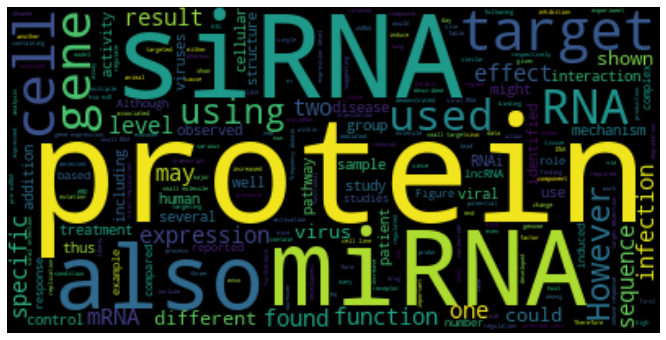

10 highest relative frequency words in topic 0:

['mirna' 'mir' 'sirna' 'rnai' 'ard' 'microrna' 'trim' 'gene_silenc' 'vzv'
 'silenc']


Percentage in topic 1: 0.0283


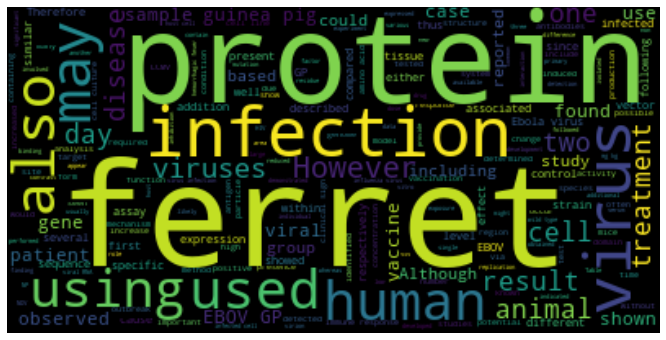

10 highest relative frequency words in topic 1:

['ferret' 'ebov' 'ndv' 'vp' 'gp' 'guinea_pig' 'lcmv' 'filoviru'
 'arenaviru' 'lassa_viru']


Percentage in topic 2: 0.0193


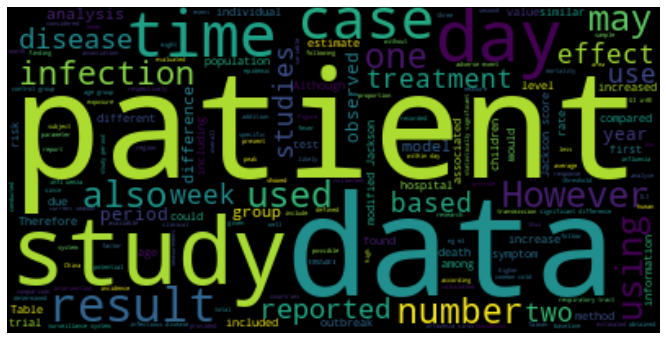

10 highest relative frequency words in topic 2:

['baselin' 'mean_sd' 'median' 'sampl_size' 'ci' 'normal_distribut'
 'confid_interv' 'weekli' 'auc' 'covari']


Percentage in topic 3: 0.0229


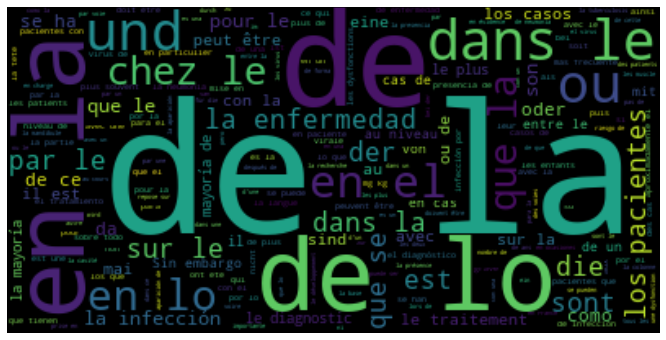

10 highest relative frequency words in topic 3:

['le' 'de' 'de_la' 'que' 'une' 'en' 'est' 'ou' 'la' 'der']


Percentage in topic 4: 0.0097


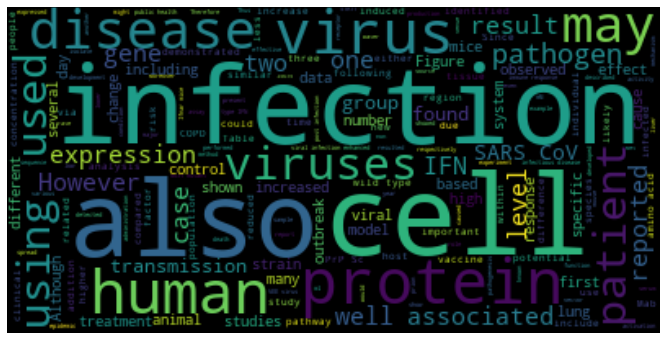

10 highest relative frequency words in topic 4:

['prion' 'ifnar' 'venu' 'sin' 'easili_access' 'cornerston' 'threat_global'
 'front_line' 'lactat_dehydrogenas' 'advanc_technolog']


Percentage in topic 5: 0.0248


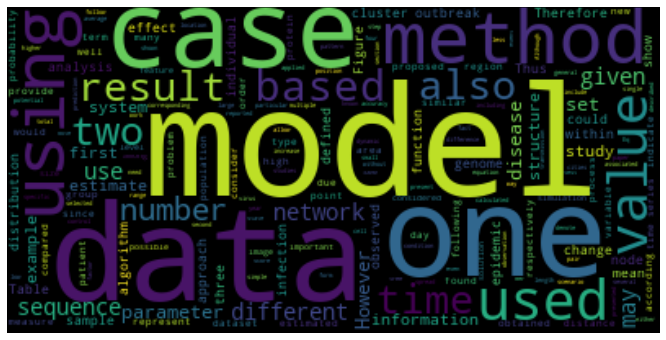

10 highest relative frequency words in topic 5:

['eq' 'node' 'forecast' 'ij' 'iter' 'spatial' 'time_seri' 'simul' 'denot'
 'pixel']


Percentage in topic 6: 0.0334


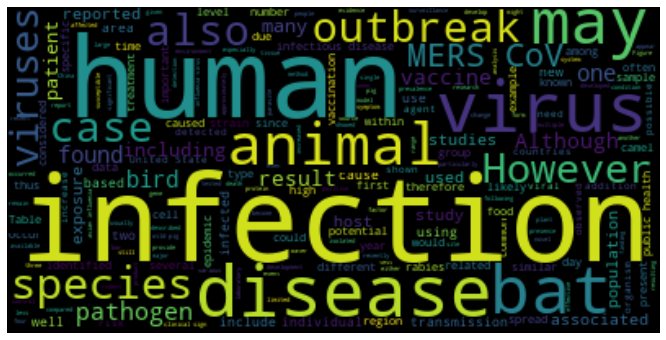

10 highest relative frequency words in topic 6:

['camel' 'wildlif' 'bird' 'dromedari_camel' 'zoonot' 'bat' 'rabi'
 'wild_bird' 'zoonot_diseas' 'habitat']


Percentage in topic 7: 0.0417


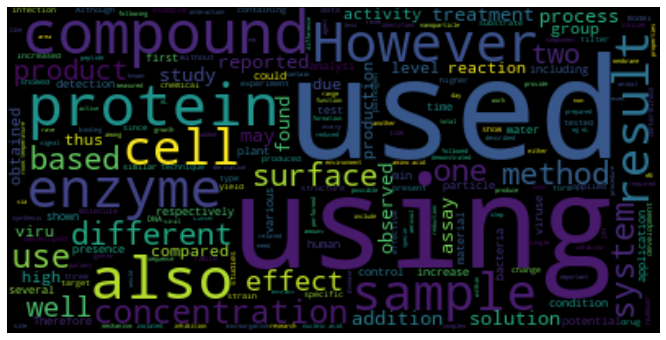

10 highest relative frequency words in topic 7:

['biosensor' 'flavonoid' 'metal' 'oxid' 'carbon' 'electrod' 'compound'
 'ethanol' 'flow_rate' 'fabric']


Percentage in topic 8: 0.0406


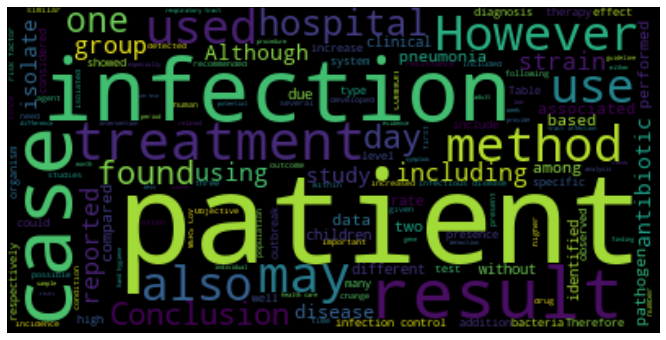

10 highest relative frequency words in topic 8:

['mrsa' 'icu' 'patient_receiv' 'blood_cultur' 'nosocomi_infect' 'patient'
 'admiss' 'chest_radiograph' 'ward' 'intub']


Percentage in topic 9: 0.0457


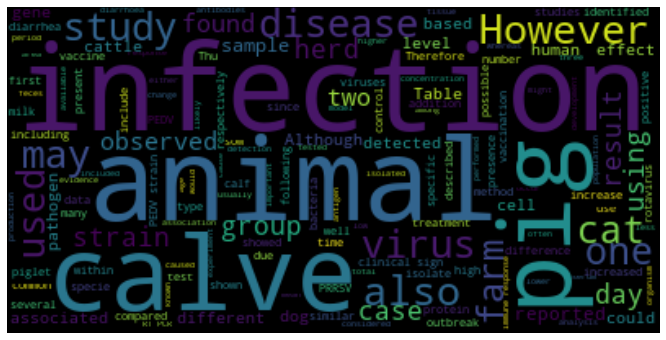

10 highest relative frequency words in topic 9:

['calv' 'pedv' 'herd' 'piglet' 'calf' 'pcv' 'milk' 'pig' 'sow' 'cow']


Percentage in topic 10: 0.0375


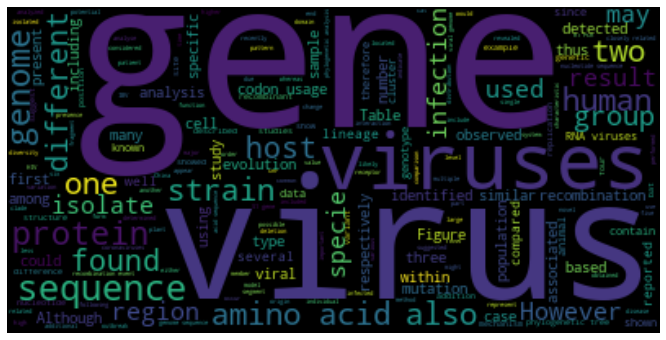

10 highest relative frequency words in topic 10:

['recombin_event' 'phylogenet_analysi' 'complet_genom' 'codon_usag'
 'phylogenet_tree' 'phylogeni' 'genet_divers' 'lineag' 'nucleotid_sequenc'
 'quasispeci']


Percentage in topic 11: 0.0362


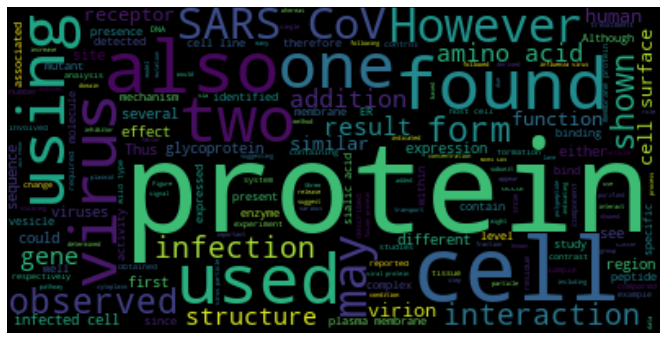

10 highest relative frequency words in topic 11:

['plasma_membran' 'sialic_acid' 'golgi' 'lectin' 'glycosyl' 'bud' 'vesicl'
 'gst' 'golgi_apparatu' 'cathepsin']


Percentage in topic 12: 0.0368


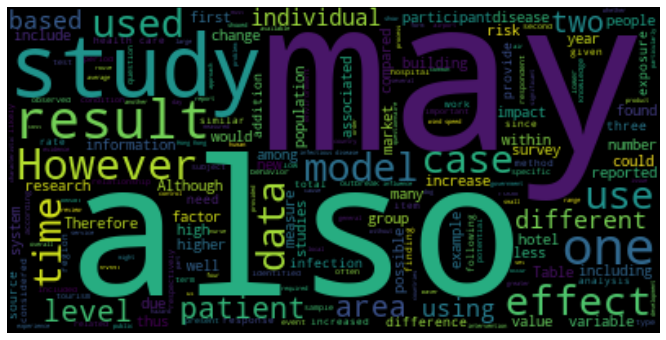

10 highest relative frequency words in topic 12:

['wind' 'emot' 'firm' 'indoor' 'percept' 'price' 'occup' 'floor'
 'ventil_system' 'pollut']


Percentage in topic 13: 0.0152


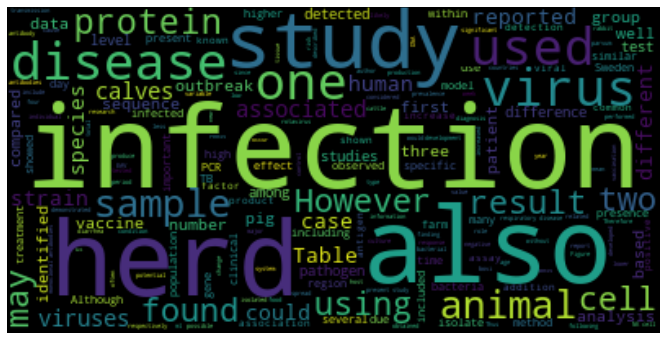

10 highest relative frequency words in topic 13:

['bcg' 'bovi' 'sweden' 'pasteur' 'denmark' 'danish' 'mycobacteri'
 'tuberculosi_tb' 'multidrug_resist' 'earliest']


Percentage in topic 14: 0.0066


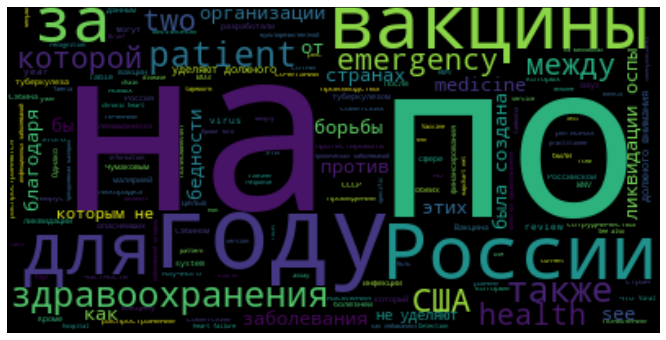

10 highest relative frequency words in topic 14:

['easili_access' 'cornerston' 'threat_global' 'lactat_dehydrogenas'
 'front_line' 'advanc_technolog' 'fill_gap' 'cautiou' 'ensur_adequ'
 'challeng_face']


Percentage in topic 15: 0.0292


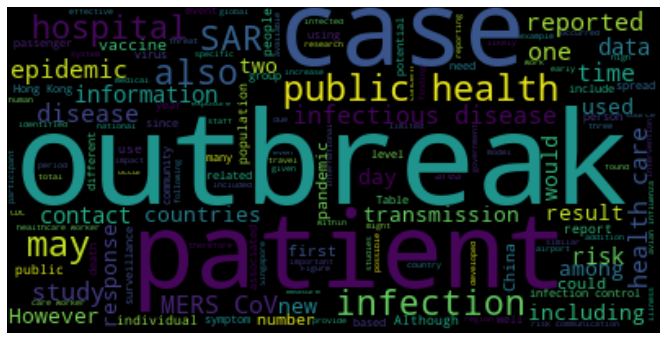

10 highest relative frequency words in topic 15:

['airport' 'passeng' 'travel' 'tourism' 'airlin' 'tourist' 'index_case'
 'health_care_worker' 'ppe' 'air_travel']


Percentage in topic 16: 0.0241


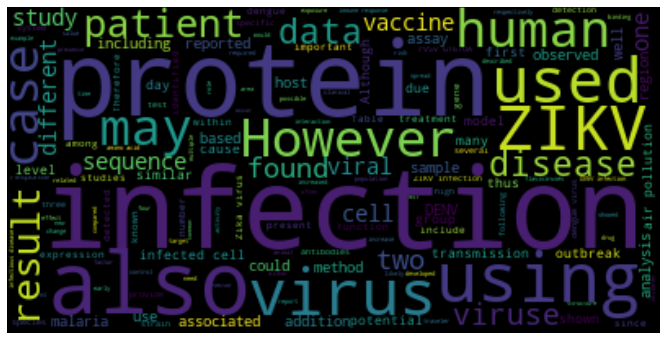

10 highest relative frequency words in topic 16:

['denv' 'dengu' 'hk' 'malaria' 'mosquito' 'flaviviru' 'flavivirus'
 'dengu_viru' 'ns' 'dengu_fever']


Percentage in topic 17: 0.0044


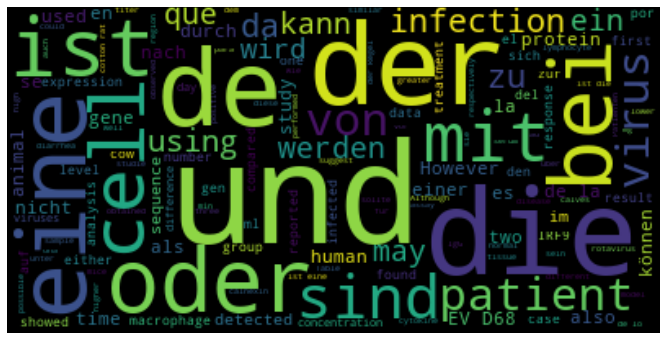

10 highest relative frequency words in topic 17:

['mo' 'gen' 'easili_access' 'cornerston' 'threat_global' 'front_line'
 'lactat_dehydrogenas' 'advanc_technolog' 'fill_gap' 'cautiou']


Percentage in topic 18: 0.0366


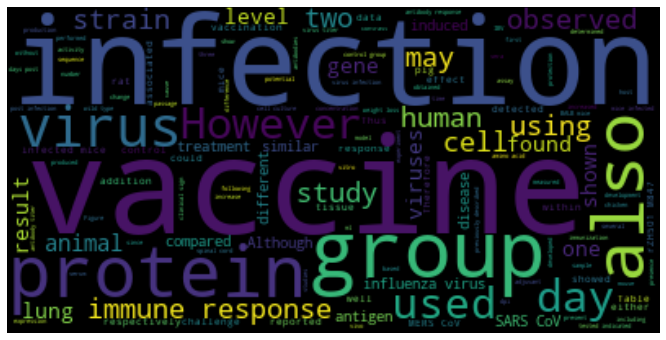

10 highest relative frequency words in topic 18:

['zikv' 'dpi' 'day_post' 'mice_inocul' 'mice_receiv' 'intranas' 'mice'
 'viral_titer' 'serum_igg' 'macaqu']


Percentage in topic 19: 0.0438


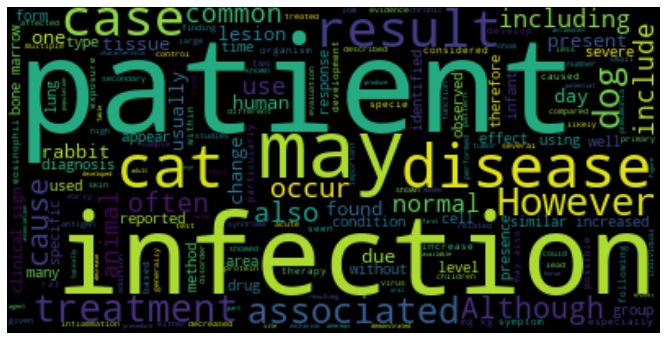

10 highest relative frequency words in topic 19:

['eosinophil' 'transfus' 'felv' 'anemia' 'biopsi' 'ulcer' 'platelet'
 'neoplasia' 'edema' 'lesion']


Percentage in topic 20: 0.0343


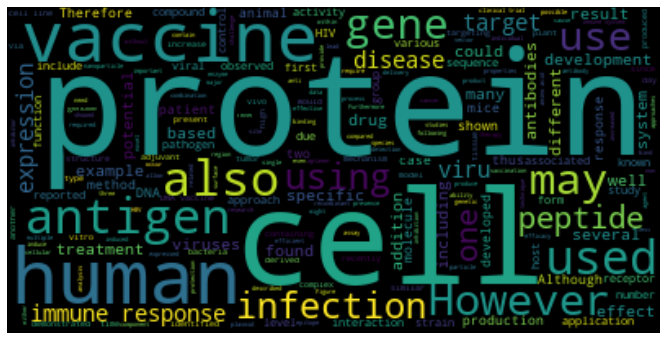

10 highest relative frequency words in topic 20:

['hbv' 'hbsag' 'melanoma' 'tumor' 'hpv' 'drug_deliveri' 'cancer' 'ebv'
 'specif_ctl' 'transgen']


Percentage in topic 21: 0.0233


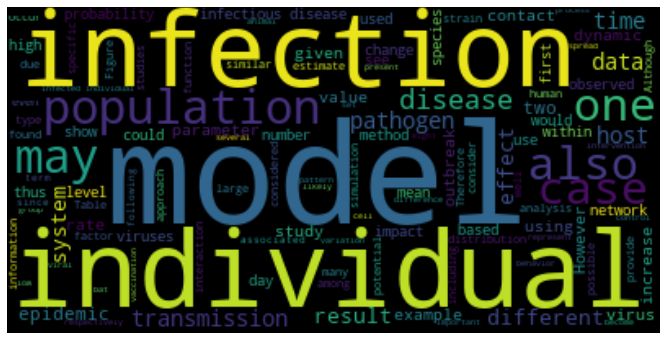

10 highest relative frequency words in topic 21:

['extinct' 'suscept_individu' 'infecti_period' 'popul_size' 'subpopul'
 'dynam' 'equilibrium' 'basic_reproduct_number' 'worm' 'driver']


Percentage in topic 22: 0.0271


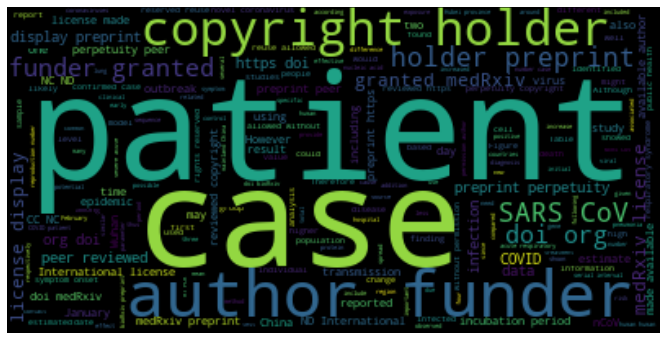

10 highest relative frequency words in topic 22:

['covid' 'ncov' 'cc_nc_nd_intern' 'copyright_holder_preprint_peer' 'wuhan'
 'licens_display_preprint_perpetu' 'author_funder_grant_medrxiv'
 'review_doi_biorxiv_preprint' 'grant_medrxiv_licens_display' 'preprint']


Percentage in topic 23: 0.0495


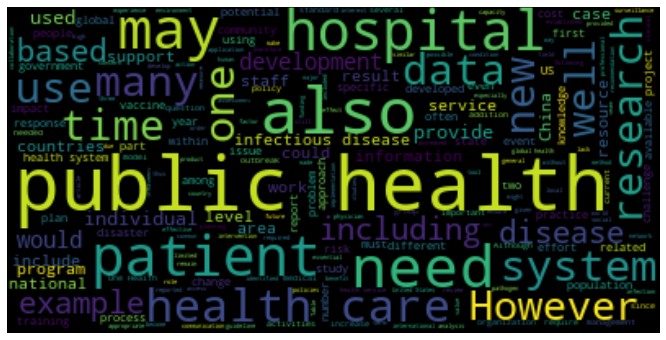

10 highest relative frequency words in topic 23:

['disast' 'collabor' 'stakehold' 'plan' 'polit' 'profession'
 'infrastructur' 'fund' 'partnership' 'secur']


Percentage in topic 24: 0.0406


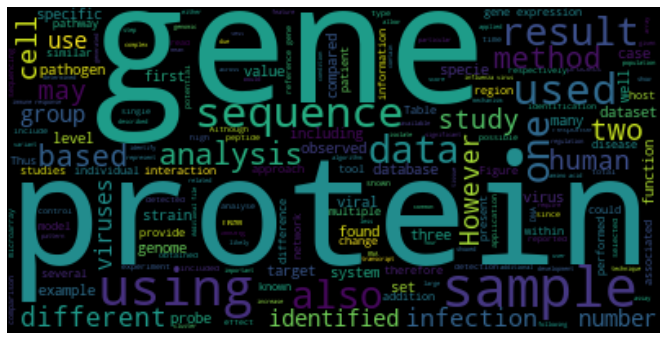

10 highest relative frequency words in topic 24:

['proteom' 'annot' 'differenti_express' 'microarray' 'transcriptom'
 'queri' 'workflow' 'signatur' 'curat' 'rna_seq']


Percentage in topic 25: 0.0307


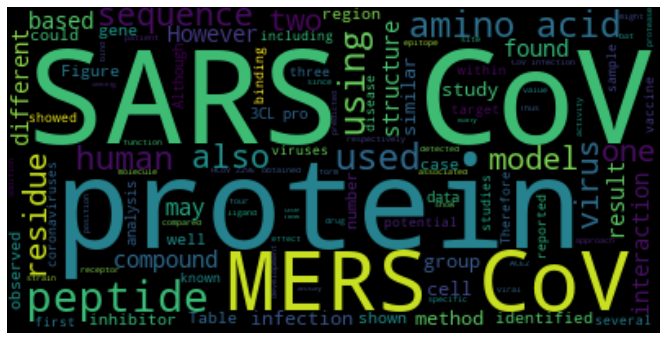

10 highest relative frequency words in topic 25:

['sar_cov' 'ace' 'cov' 'dpp' 'dock' 'homolog_model' 'sar_cov_mer_cov'
 'mer_cov' 'hku' 'spike_protein']


Percentage in topic 26: 0.0502


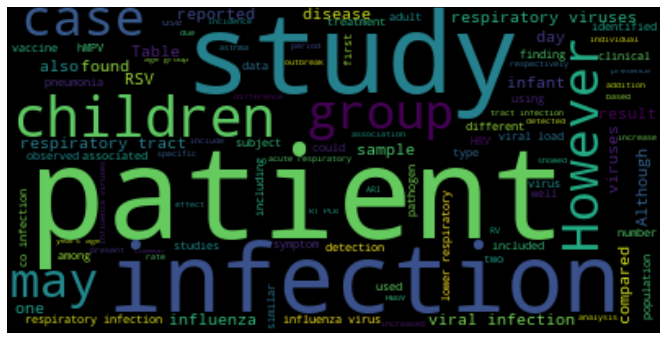

10 highest relative frequency words in topic 26:

['rsv' 'hrv' 'hmpv' 'hbov' 'respiratori_virus' 'rv' 'piv' 'ari' 'infant'
 'children']


Percentage in topic 27: 0.0377


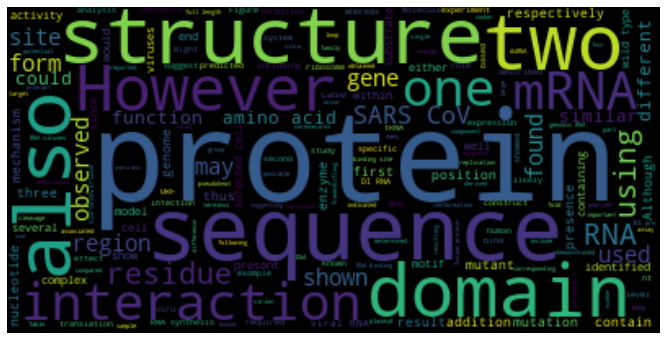

10 highest relative frequency words in topic 27:

['nsp' 'ibv' 'frameshift' 'trna' 'nsp_nsp' 'ibv_strain' 'fmdv'
 'leader_sequenc' 'rna_synthesi' 'helix']


Percentage in topic 28: 0.0309


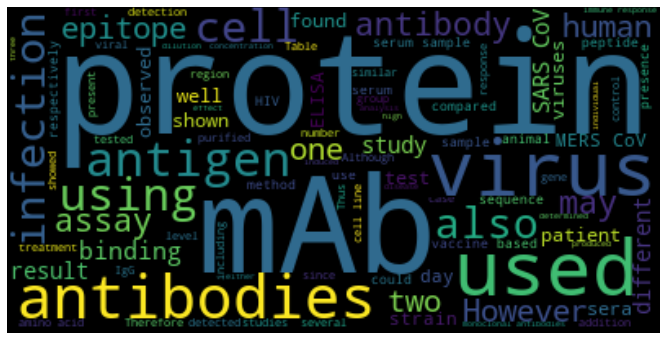

10 highest relative frequency words in topic 28:

['mab' 'neutral_activ' 'neutral_mab' 'hybridoma' 'env' 'igg' 'ab' 'ade'
 'igm' 'fiv']


Percentage in topic 29: 0.0497


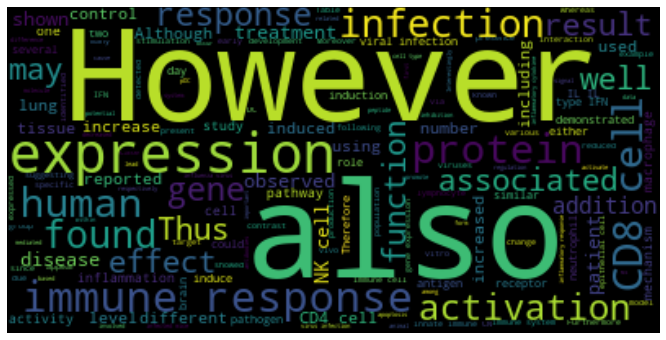

10 highest relative frequency words in topic 29:

['nk_cell' 'tlr' 'cxcl' 'cytokin' 'tnf' 'il_il' 'demyelin' 'chemokin'
 'pdc' 'astrocyt']


Percentage in topic 30: 0.0362


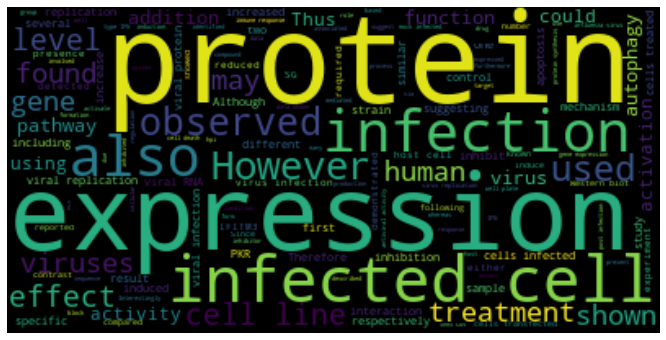

10 highest relative frequency words in topic 30:

['isg' 'ifitm' 'pkr' 'hpi' 'rig' 'autophagi' 'mav' 'chikv' 'sg' 'gfp']


Percentage in topic 31: 0.0286


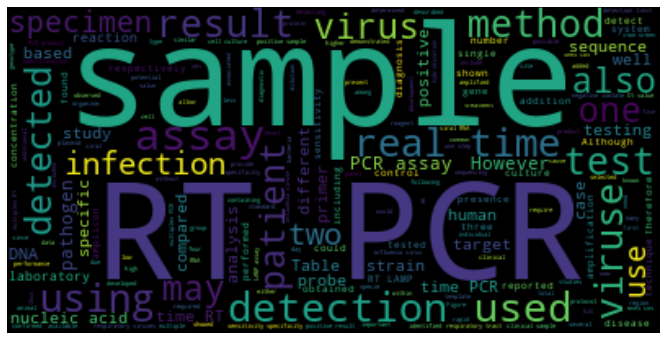

10 highest relative frequency words in topic 31:

['real_time_rt_pcr' 'amplicon' 'primer_set' 'real_time_pcr' 'amplif'
 'primer_probe' 'nest_pcr' 'dna_extract' 'pcr_product' 'rt_pcr']




In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

for t in np.arange(32):
    try:
    word_clouds(train_topic_fin_rel, t, 200, stop_words, evalinfo)
    except:
        print('failure')
        print(t)

# Similarity Matching

Finally let's create a mechanism to take a new document and find the 10 most similar documents in our training database. We'll use the FAISS package to create a fast indexing system. Faiss is a library for efficient similarity search and clustering of dense vectors that came out of Facebook Research: https://github.com/facebookresearch/faiss

We'll use the topic scores generated by the topic model as the dense vectors to pass into the faiss index. Then after scoring a new document with it's topic scores, we'll look up the most similar documents we have available based on cosine similarity. For brevity's sake we'll just return the topic score of the new document, the document title, and the document titles of the most similar articles. A lay-person's quick review of these items seems to indicate the titles returned often match up closely with the new document provided. The similarity score shown is the cosine similarity.

An extension of this work could be to do the same at the sentence or paragraph level to find specific areas of similarity rather than look at the full document level. This could provide value for researchers looking for very specific topics, rather than general similarities. In this case a topic model based approach could suffice, where paragraphs became documents rather than sentences, but topic models typically are not as useful on smaller texts. Instead, using an approach like BERT do create sentence or paragraph embeddings would be a logical place to start.

In [13]:
# FAISS - Create index based on training topic scores

ncentroids = 100
k = 4
matrix_conv = np.ascontiguousarray(train_wc.topic_scores.astype('float32'))
dim_index = len(matrix_conv[0])
faiss.normalize_L2(matrix_conv)
quantizer = faiss.IndexFlatL2(dim_index)  # the other index
index = faiss.IndexIVFFlat(quantizer, dim_index, ncentroids, faiss.METRIC_INNER_PRODUCT)
assert not index.is_trained
index.train(matrix_conv)
assert index.is_trained

index.add(matrix_conv)                  # add may be a bit slower as well

In [15]:
# Create test data matrix, randomly sample from test set, and return 10 most similar candidates that have document titles


test_matrix = np.ascontiguousarray(test_wc.topic_scores.astype('float32'))

testD, testI = index.search(test_matrix, 50)
rand = random.randint(0, (len(test) - 1))

print(f"Topic Scores for new article: \n {test_wc.topic_scores.iloc[rand]}")
print(f"Title of new article: \n{test[rand][1]}\n")
print("Most Similar Articles:\n")
counter = 0
valid = 1

for val in testI[rand]:
    counter = counter + 1
    if valid > 10:
        break
    if test[rand][1] == '':
        break
    if train[val][1] == test[rand][1]:
        continue
    elif train[val][1] == '':
        continue
    else:
        print(f"{valid}) Similarity Score = {np.around(testD[rand][counter], 3)}\nTitle: {train[val][1]} \nPublication: {train[val][0]}\n")
        valid = valid + 1

Topic Scores for new article: 
 0     0.000005
1     0.027801
2     0.000005
3     0.000005
4     0.000005
5     0.000005
6     0.006180
7     0.000005
8     0.001883
9     0.005265
10    0.000005
11    0.101692
12    0.000005
13    0.000005
14    0.000005
15    0.000005
16    0.004100
17    0.000005
18    0.163875
19    0.000005
20    0.566667
21    0.000005
22    0.000005
23    0.000555
24    0.000005
25    0.001207
26    0.035097
27    0.015569
28    0.068361
29    0.001658
30    0.000005
31    0.000005
Name: 471, dtype: float64
Title of new article: 
Virus-like particles as a highly efficient vaccine platform: Diversity of targets and production systems and advances in clinical development

Most Similar Articles:

1) Similarity Score = 0.5820000171661377
Title: Preclinical Development and Production of Virus-Like Particles As Vaccine Candidates for Hepatitis C 
Publication: comm_use_subset

2) Similarity Score = 0.5789999961853027
Title: molecules Applications of Gold Nanoparticles

# Possible Extensions

1. Scale up to avoid random sampling
2. BERT - Find similar sentences or paragraphs rather than topics
3. One of the topics appears to just be articles written in Spanish - translate